In [1]:
import datasets
import pandas as pd
import transformers
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

import shap

In [2]:
%cd ../../

d:\python\Toxic-comment-classification


In [3]:
path = 'kaggle/input/'
submission_path = 'kaggle/working/transformers/'
comp = 'jigsaw-toxic-comment-classification-challenge/'
clean_data_path = 'clean_data/'
TRAIN_DATA_FILE=f'{path}{comp}train.csv.zip'
TEST_DATA_FILE=f'{path}{comp}test.csv.zip'
CLEAN_TRAIN_DATA_FILE=f'{clean_data_path}data_train_cleaned_vanilla2.txt'
CLEAN_TEST_DATA_FILE=f'{clean_data_path}data_test_cleaned_vanilla2.txt'
SAMPLE_SUBMISSION=f'{path}{comp}sample_submission.csv.zip'
checkpoint_path = 'model_checkpoint/transformers/'
classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [4]:
def read_from_file(filename):
    with open(filename, 'r') as f:
        return f.read().splitlines()  

In [5]:
new_df = pd.DataFrame()
train = pd.read_csv(TRAIN_DATA_FILE)
new_df['text'] = read_from_file(CLEAN_TRAIN_DATA_FILE)
new_df['labels'] = train[classes].values.tolist()

In [6]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
# Load tokenizer and model from checkpoint

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased", truncation=True, padding="max_length", max_length=128, return_tensors='pt')
model = DistilBertForSequenceClassification.from_pretrained("results\\checkpoint-17000")
model.config.id2label = {0: 'toxic', 1: 'severe_toxic', 2: 'obscene', 3: 'threat', 4: 'insult', 5: 'identity_hate'}
model.config.label2id = {'toxic': 0, 'severe_toxic': 1, 'obscene': 2, 'threat': 3, 'insult': 4, 'identity_hate': 5}

pred = transformers.pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device='cuda',
    return_all_scores=True,
)

d:\anaconda\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
d:\anaconda\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [8]:
explainer = shap.Explainer(pred)

In [16]:
def get_comments_by_class(label):
    class_index = classes.index(label)
    comments = new_df[new_df['labels'].apply(lambda x: x[class_index] == 1)]['text']
    return comments

def get_shap_values_by_class(label, num_comments=10):
    comments = get_comments_by_class(label)
    shap_values = explainer(comments.head(num_comments).tolist())
    return shap_values

In [10]:
get_comments_by_class('toxic').head()

6                dick before you piss around on my work
12    what is it talk what is an exclusive group of ...
16    bye do not look come or think of comming back ...
42    you are gay or antisemmitian archangel white t...
43               fuck your filthy mother in the ass dry
Name: text, dtype: object

In [11]:
sample_row = new_df.sample(n=1, weights=new_df['labels'].apply(lambda x: 1 in x))
sample_row

,text,labels
17652,jimbo wales wont stop messing with my ass pus ...,"[1, 0, 1, 0, 1, 0]"


In [12]:
shap_values = explainer(sample_row['text'].tolist())
shap.plots.text(shap_values)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


PartitionExplainer explainer: 100%|██████████| 10/10 [00:15<00:00,  1.32s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 11it [00:23,  4.64s/it]                        


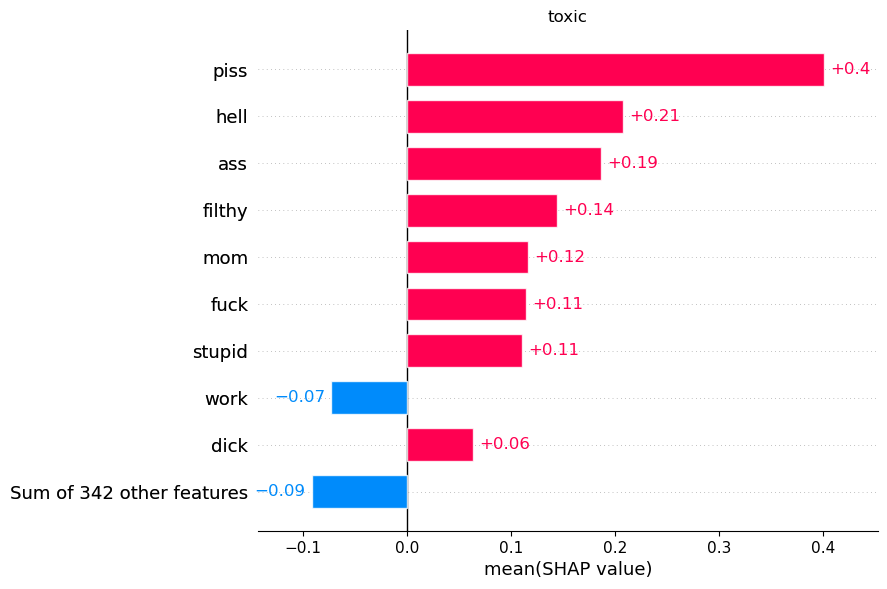

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 8/10 [00:10<00:00,  5.30it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 11it [00:22,  4.58s/it]                        


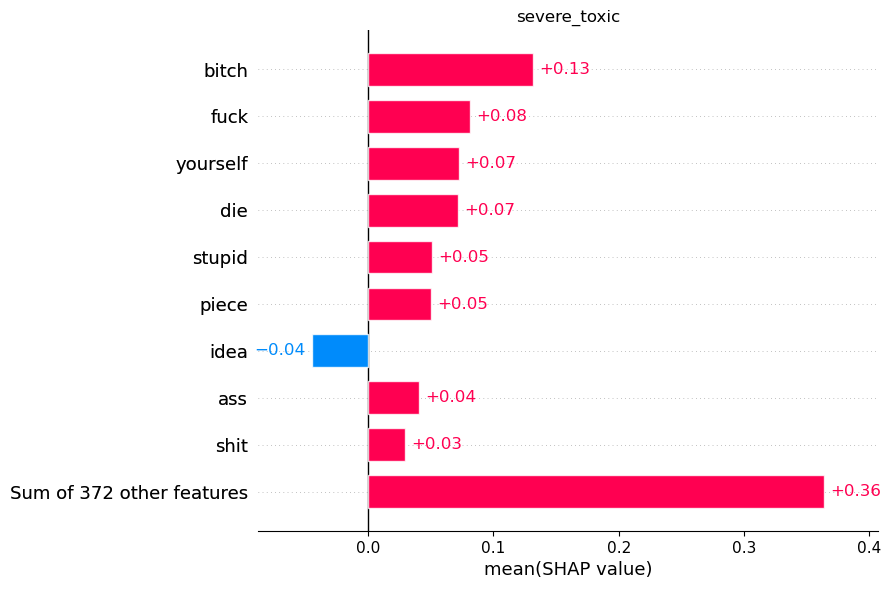

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 11it [00:23,  5.88s/it]                        


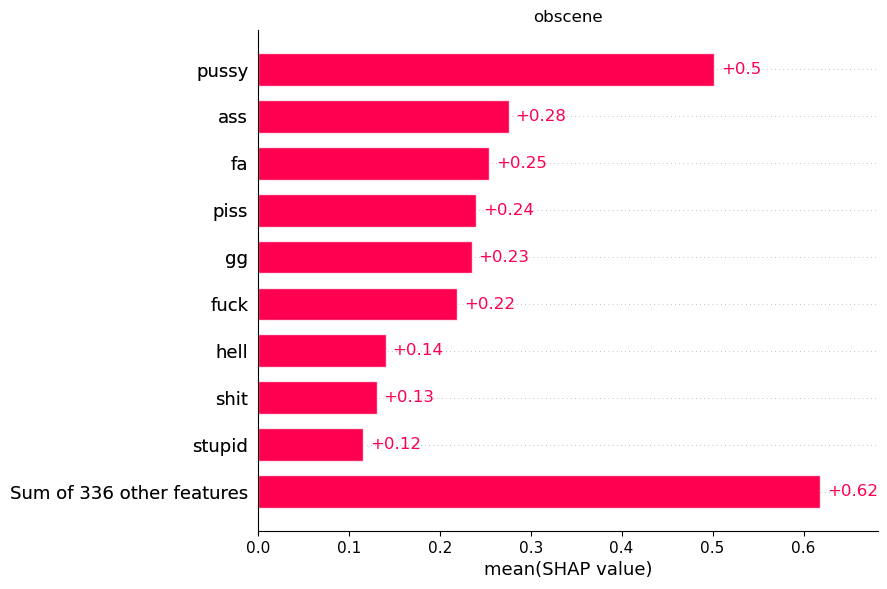

PartitionExplainer explainer: 11it [00:19,  3.87s/it]                        


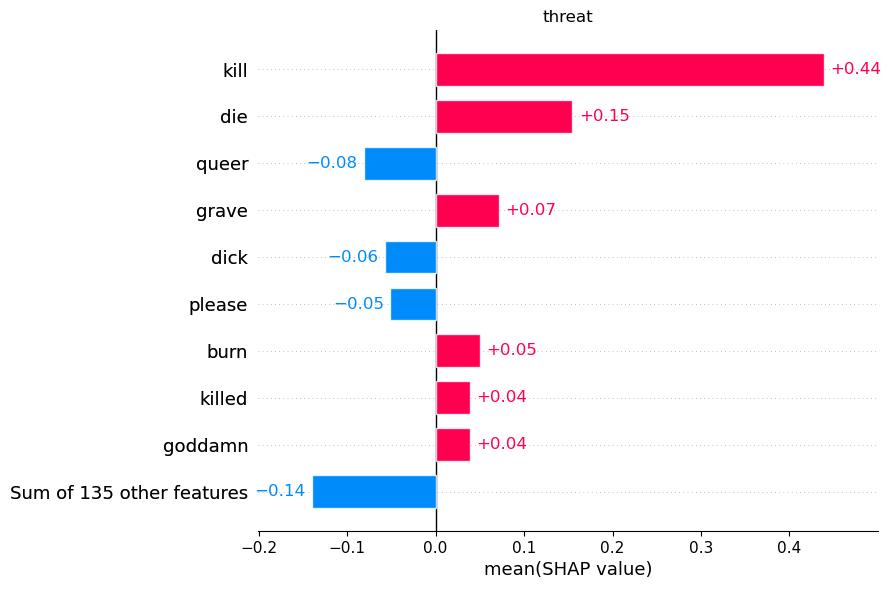

PartitionExplainer explainer: 11it [00:18,  3.79s/it]                        


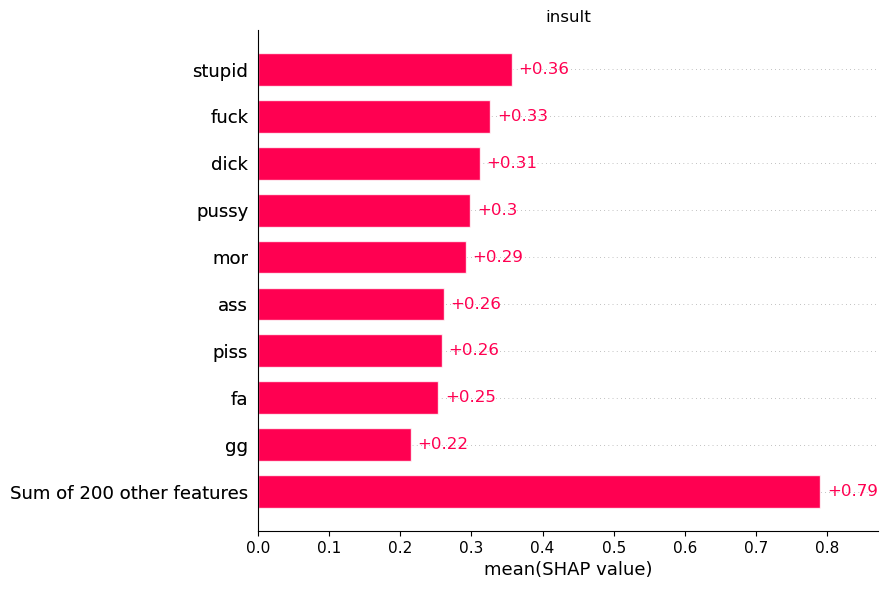

PartitionExplainer explainer: 11it [00:24,  4.03s/it]                        


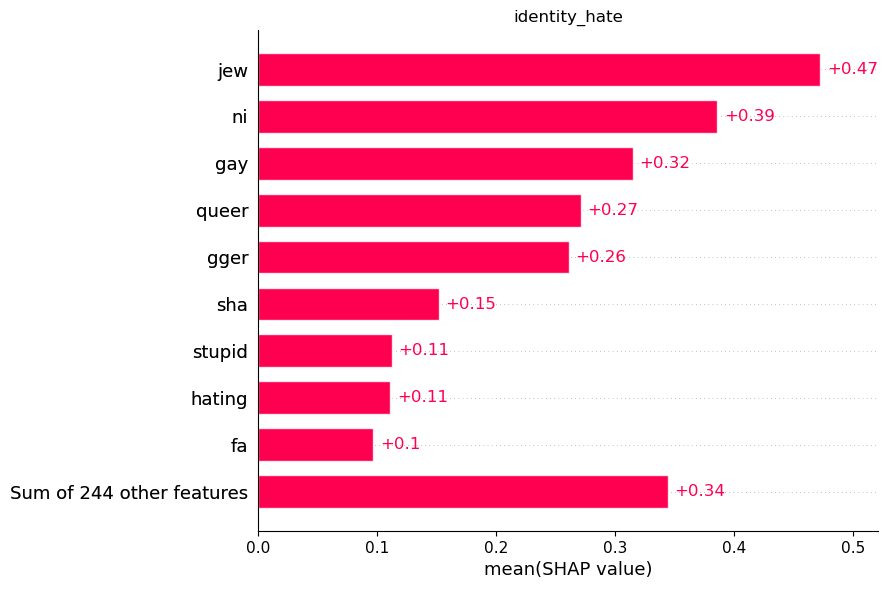

In [17]:
import matplotlib.pyplot as plt

for label in classes:
    plt.title(label)
    shap_values = get_shap_values_by_class(label, 10)
    shap.plots.bar(shap_values[:, :, label].mean(0), show = True, max_display=10)
    plt.show()
    